this script plots countries' contribution to science

In [2]:
import pandas as pd
import numpy as np
from itertools import product
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib import gridspec
from matplotlib.patches import Patch

In [21]:
cntry_fund_path='../../data/nf_folder/Data/DerivedData/Derived/cntry_fund_frac.csv'
pubs_path="../../data/nf_folder/Data/DerivedData/CleanedRawData/pub.pkl"
flag_path='../../data/nf_folder/Data/AdditionalData/country_WoS_ECI_WB_flags.tsv'
region_path="../../data/nf_folder/Data/AdditionalData/cntry_region.xlsx"

In [22]:
cntry_funding_path='../../data/nf_folder/Figs/cntry_funding_frac.pdf'

In [23]:
cntry_fund=pd.read_csv(cntry_fund_path)
cntry_fund=cntry_fund[cntry_fund.funder!='Not-Funded']
cntry_fund.head()

,funder,year,intcol,cnt
0,Afghanistan,2010,1,1.000000
1,Afghanistan,2011,1,0.333333
2,Afghanistan,2012,1,0.333333
3,Afghanistan,2015,0,0.148352
4,Afghanistan,2015,1,0.279167


In [8]:
pubs_df = pd.read_pickle(pubs_path)
pubs_df.head()

,id,year,dis,type,author,funder,author_distinct,funder_distinct,funded,IntCol
0,60694041,2017,9,1,"[Canada, United States]","[United States, United States]","[United States, Canada]",[United States],1,1
1,48573156,2012,89,1,[France],Not-Funded,[France],Not-Funded,0,0
2,55323671,2015,89,1,"[France, Chile]","[Chile, Chile, Chile, Chile, Chile]","[Chile, France]",[Chile],1,1
3,57633115,2016,31,1,"[Switzerland, United States]",[Switzerland],"[Switzerland, United States]",[Switzerland],1,1
4,64831413,2018,99,1,[China],"[China, China, China, China, China, China]",[China],[China],1,0


In [9]:
flag_df=pd.read_csv(flag_path, sep='\t')[['WoS','Code']]
flag_df.head()

,WoS,Code
0,Albania,ALB
1,Algeria,DZA
2,Angola,AGO
3,Argentina,ARG
4,Australia,AUS


In [10]:
region=pd.read_excel(region_path)
region=region[['cntry','region']]
region.head()

,cntry,region
0,Afghanistan,Asia
1,Albania,Other Europe
2,Algeria,Africa
3,Andorra,Other Europe
4,Angola,Africa


In [11]:
pubs_df.head()

,id,year,dis,type,author,funder,author_distinct,funder_distinct,funded,IntCol
0,60694041,2017,9,1,"[Canada, United States]","[United States, United States]","[United States, Canada]",[United States],1,1
1,48573156,2012,89,1,[France],Not-Funded,[France],Not-Funded,0,0
2,55323671,2015,89,1,"[France, Chile]","[Chile, Chile, Chile, Chile, Chile]","[Chile, France]",[Chile],1,1
3,57633115,2016,31,1,"[Switzerland, United States]",[Switzerland],"[Switzerland, United States]",[Switzerland],1,1
4,64831413,2018,99,1,[China],"[China, China, China, China, China, China]",[China],[China],1,0


calculate the number of funded publication each year

In [12]:
def get_fundedann(data,collsig):
    data=data[data.IntCol>=collsig]#to decide whethere include no-international collaboration or not
    funded_ann=data[data.funded==1]
    funded_ann=funded_ann.groupby(['year']).size()
    return funded_ann

normalize country's to proportion

In [13]:
def get_ratio(data,funded_ann,collsig):
    data=data[data.intcol>=collsig]#to decide whethere include no-international collaboration or not
    cntry_ratio=data.groupby(['funder','year'])['cnt'].sum().reset_index()
    cntry_ratio=cntry_ratio.pivot_table(index='year',columns='funder',values='cnt',fill_value=0)
    cntry_ratio=cntry_ratio.div(funded_ann, axis=0)
    return cntry_ratio

In [25]:
n=10
topn=cntry_fund.groupby('funder')[
    'cnt'].sum().sort_values(ascending=False).head(n).index.values


get the contribution of top 10 countries

In [26]:
funded_ann=get_fundedann(pubs_df,0)
cntry_ratio=get_ratio(cntry_fund,funded_ann,0)
topn_df=cntry_ratio[topn].reset_index()
topn_df=topn_df.melt(id_vars='year')  
topn_df=topn_df.merge(flag_df,left_on='funder',right_on='WoS',how='left')

get the contribution to international collaboration of top 10 countries

In [27]:
fundedcoll_ann=get_fundedann(pubs_df,1)
cntrycoll_ratio=get_ratio(cntry_fund,fundedcoll_ann,1)
topn_coll=cntrycoll_ratio[topn].reset_index()
topn_coll=topn_coll.melt(id_vars='year') 
topn_coll=topn_coll.merge(flag_df,left_on='funder',right_on='WoS',how='left')

get the funded publications by regions

In [28]:
regfund=cntry_ratio.reset_index()
regfund=regfund.melt(id_vars='year')
regfund=regfund.merge(region,left_on='funder',right_on='cntry',how='left')
regfund=regfund.groupby(['year','region'])['value'].sum().reset_index(name='count')
regfund=regfund.pivot_table(index='year',columns='region',values='count')
regfund=regfund.rename(columns={'EU':'EU-Members'})

In [29]:
clist=['#A6341B','#F2506E']+['#D0D2F2']*8
def plot(data,ax,texty,text):
    sns.lineplot(x='year',y='value',hue='funder',data=data,legend=False,
                 ax=ax,hue_order=topn,palette=clist,marker='o',linewidth=1,markersize=5)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    for ind, code in enumerate(text):
        ax.text(2018,texty[ind],code)
    return ax

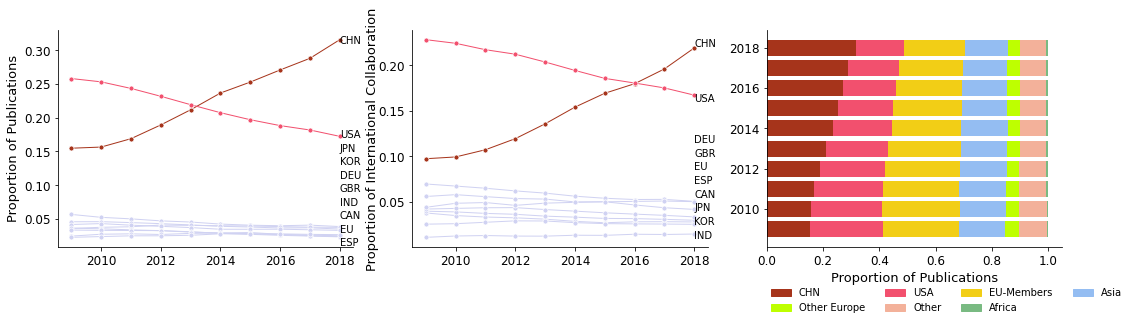

In [32]:
#{'#F2CB05':yellow,'#88C9F2':blue,'#C5C9C7':gray,'#F74F5A'}
years=[2009,2010,2011,2012,2013,2014,2015,2016,2017,2018]

fig, ax=plt.subplots(nrows=1,ncols=3,figsize=(18,4))
ax0=ax[0]
ax1=ax[1]
ax2=ax[2]


texty=[0.31,0.17,0.15,0.13,0.11,0.09,0.07,0.05,0.03,0.01]
text=topn_df[topn_df.year==2018].sort_values(by='value',ascending=False)['Code'].values
plot(topn_df,ax0, texty, text)
ax0.set_xlabel("")
ax0.set_ylabel("Proportion of Publications",fontsize=13)
ax0.tick_params(axis='both', which='major', labelsize=12)


texty=[0.22,0.16,0.115,0.1,0.085,0.07,0.055,0.04,0.025,0.01]
text=topn_coll[topn_coll.year==2018].sort_values(by='value',ascending=False)['Code'].values
plot(topn_coll,ax1,texty,text)
ax1.set_xlabel("")
ax1.set_ylabel("Proportion of International Collaboration",fontsize=13,labelpad=0)
ax1.tick_params(axis='both', which='major', labelsize=12)

chn = regfund.loc[years,'China'].values
usa = regfund.loc[years,'USA'].values
eu = regfund.loc[years,'EU-Members'].values
asia = regfund.loc[years,'Asia'].values
africa = regfund.loc[years,'Africa'].values
othereu = regfund.loc[years,'Other Europe'].values
other = regfund.loc[years,'Other'].values
ax2.barh(years, chn,label='CHN',color='#A6341B')
ax2.barh(years,usa,label='USA',left = chn,color='#F2506E')
ax2.barh(years,eu,label='EU',left=chn+usa,color='#F2CE16')
ax2.barh(years,asia,label='Asia',left=chn+usa+eu,color='#94BDF2')
ax2.barh(years,othereu,label='Europe',left=chn+usa+eu+asia,color='#BEFF00')
ax2.barh(years,other,label='Other',left=chn+usa+eu+asia+othereu,color='#F3B19A')
ax2.barh(years,africa,label='Africa',left=chn+usa+eu+asia+othereu+other,color='#79BA82')
ax2.spines['right'].set_visible(False)
ax2.spines['top'].set_visible(False)
ax2.tick_params(axis='both', which='major', labelsize=12)
legend=[Patch(label='CHN',color='#A6341B'),
        Patch(label='Other Europe',color='#BEFF00'),
       Patch(label='USA',color='#F2506E'),
        Patch(label='Other',color='#F3B19A'),
       Patch(label='EU-Members',color='#F2CE16'),
        Patch(label='Africa',color='#79BA82'),
       Patch(label='Asia',color='#94BDF2')]
ax2.set_xlabel("Proportion of Publications",fontsize=13)

ax2.legend(handles=legend,ncol=4,loc=(0,-0.32),frameon=False)

plt.tick_params(axis='both', which='major', labelsize=12)
plt.savefig(cntry_funding_path,bbox_inches='tight')